In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'icv83551/assignments/assignment1/'
FOLDERNAME = 'icv83551/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/icv83551/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/icv83551/assignments/assignment1/icv83551/datasets
/content/drive/My Drive/icv83551/assignments/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from icv83551.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#%load_ext autoreload
#%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from icv83551.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'icv83551/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from icv83551.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [21]:
# Use the validation set to tune the learning rate and regularization strength

from icv83551.classifiers.linear_classifier import Softmax

learning_rates = np.logspace(-7, -3, 10)
regularization_strengths = np.logspace(3, 5.5, 6)
batch_sizes = [50, 100, 200, 300, 400]

results = {}
best_val = -1
best_softmax = None
max_iter = 2000

for lr in learning_rates:
    for reg in regularization_strengths:
      for bs in batch_sizes:
          softmax = Softmax()
          softmax.train(
              X_train_feats,
              y_train,
              learning_rate=lr,
              reg=reg,
              num_iters=max_iter,
              batch_size=bs,
              verbose=False
          )

          # Evaluate on train and val
          y_train_pred = softmax.predict(X_train_feats)
          train_accuracy = np.mean(y_train_pred == y_train)

          y_val_pred = softmax.predict(X_val_feats)
          val_accuracy = np.mean(y_val_pred == y_val)

          # Store results
          results[(lr, reg, bs)] = (train_accuracy, val_accuracy)

          # Track the best model
          if val_accuracy > best_val:
              best_val = val_accuracy
              best_softmax = softmax

          print(f'lr={lr:.0e}, reg={reg:.0e}, bs={bs}: train={train_accuracy:.3f}, val={val_accuracy:.3f}')

# Print out results.
for lr, reg, bs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, bs)]
    print('lr %e reg %e bs %d train accuracy: %f val accuracy: %f' % (
                lr, reg, bs, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

lr=1e-07, reg=1e+03, bs=50: train=0.093, val=0.093
lr=1e-07, reg=1e+03, bs=100: train=0.115, val=0.127
lr=1e-07, reg=1e+03, bs=200: train=0.086, val=0.085
lr=1e-07, reg=1e+03, bs=300: train=0.099, val=0.097
lr=1e-07, reg=1e+03, bs=400: train=0.107, val=0.089
lr=1e-07, reg=3e+03, bs=50: train=0.116, val=0.108
lr=1e-07, reg=3e+03, bs=100: train=0.113, val=0.109
lr=1e-07, reg=3e+03, bs=200: train=0.101, val=0.106
lr=1e-07, reg=3e+03, bs=300: train=0.112, val=0.101
lr=1e-07, reg=3e+03, bs=400: train=0.107, val=0.096
lr=1e-07, reg=1e+04, bs=50: train=0.136, val=0.146
lr=1e-07, reg=1e+04, bs=100: train=0.144, val=0.152
lr=1e-07, reg=1e+04, bs=200: train=0.115, val=0.134
lr=1e-07, reg=1e+04, bs=300: train=0.129, val=0.139
lr=1e-07, reg=1e+04, bs=400: train=0.114, val=0.110
lr=1e-07, reg=3e+04, bs=50: train=0.417, val=0.421
lr=1e-07, reg=3e+04, bs=100: train=0.425, val=0.432
lr=1e-07, reg=3e+04, bs=200: train=0.423, val=0.425
lr=1e-07, reg=3e+04, bs=300: train=0.423, val=0.423
lr=1e-07, reg=3e

In [23]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.439


In [24]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


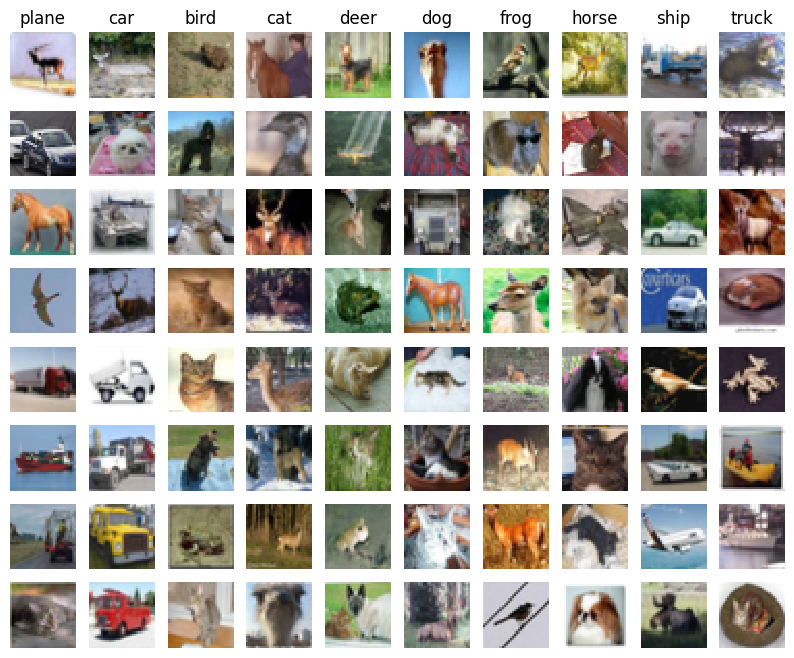

In [25]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ there are misclassifications that makes sense of few aspects. one is a visual aspect - there are classes with inherit visual similarity to begin with, for example, truck and car are can be confused because they have similar features such as: wheels, windows, rectangular shapes, etc. from the other hand, there are also odd misclassifications, for example, frog or deer being classified as truck. those might occur due to background colors, textures, or specific image characteristics rather than the main object. the model operates on pixel patterns and doesn't understand semantic categories, so it can confuse objects that share visual features as those describe before.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [5]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [6]:
from icv83551.classifiers.fc_net import TwoLayerNet
from icv83551.solver import Solver

from itertools import product

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

best_net = None
best_val = -1

hidden_sizes = [50, 100, 200, 300, 500]
learning_rates = [1e-3, 3e-3, 1e-2]
regularization_strengths = [1e-4, 1e-3, 3e-3]
weight_scales = [1e-3, 3e-3, 1e-2]
batch_sizes = [5, 10, 20]

for hs, lr, reg, ws, bs in product(
    hidden_sizes,
    learning_rates,
    regularization_strengths,
    weight_scales,
    batch_sizes
):

    net = TwoLayerNet(
        input_dim=input_dim,
        hidden_dim=hs,
        num_classes=num_classes,
        weight_scale=ws,
        reg=reg
    )

    solver = Solver(
        net,
        data,
        update_rule='sgd',
        optim_config={'learning_rate': lr},
        lr_decay=0.95,
        num_epochs=10,
        batch_size=bs,
        verbose=False
    )

    solver.train()
    val_acc = solver.val_acc_history[-1]

    if val_acc > best_val:
        best_val = val_acc
        best_net = net

    print(f"{hs=}, {lr=}, {reg=}, {ws=}, {bs=} -> val={val_acc:.3f}")


hs=50, lr=0.001, reg=0.0001, ws=0.001, bs=5 -> val=0.519
hs=50, lr=0.001, reg=0.0001, ws=0.001, bs=10 -> val=0.467
hs=50, lr=0.001, reg=0.0001, ws=0.001, bs=20 -> val=0.318
hs=50, lr=0.001, reg=0.0001, ws=0.003, bs=5 -> val=0.526
hs=50, lr=0.001, reg=0.0001, ws=0.003, bs=10 -> val=0.486
hs=50, lr=0.001, reg=0.0001, ws=0.003, bs=20 -> val=0.368
hs=50, lr=0.001, reg=0.0001, ws=0.01, bs=5 -> val=0.521
hs=50, lr=0.001, reg=0.0001, ws=0.01, bs=10 -> val=0.519
hs=50, lr=0.001, reg=0.0001, ws=0.01, bs=20 -> val=0.422
hs=50, lr=0.001, reg=0.001, ws=0.001, bs=5 -> val=0.523
hs=50, lr=0.001, reg=0.001, ws=0.001, bs=10 -> val=0.461
hs=50, lr=0.001, reg=0.001, ws=0.001, bs=20 -> val=0.331
hs=50, lr=0.001, reg=0.001, ws=0.003, bs=5 -> val=0.523
hs=50, lr=0.001, reg=0.001, ws=0.003, bs=10 -> val=0.475
hs=50, lr=0.001, reg=0.001, ws=0.003, bs=20 -> val=0.376
hs=50, lr=0.001, reg=0.001, ws=0.01, bs=5 -> val=0.524
hs=50, lr=0.001, reg=0.001, ws=0.01, bs=10 -> val=0.508
hs=50, lr=0.001, reg=0.001, ws=0.

In [7]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.588


In [8]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
